In [1]:
from numpy.random import seed
seed(1)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import itertools

import keras
from keras.applications import ResNet50, Xception
from keras.models import Sequential, Model
from keras.layers import Activation,Dense, Dropout, Flatten, Conv2D, MaxPool2D,AveragePooling2D,GlobalMaxPooling2D
from keras import backend as K
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras import regularizers
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

np.random.seed(123)


In [2]:
def basic_EDA(df):
    size = df.shape
    sum_duplicates = df.duplicated().sum()
    sum_null = df.isnull().sum().sum()
    is_NaN = df. isnull()
    row_has_NaN = is_NaN. any(axis=1)
    rows_with_NaN = df[row_has_NaN]
    count_NaN_rows = rows_with_NaN.shape
    return print("Number of Samples: %d,\nNumber of Features: %d,\nDuplicated Entries: %d,\nNull Entries: %d,\nNumber of Rows with Null Entries: %d %.1f%%" %(size[0],size[1], sum_duplicates, sum_null,count_NaN_rows[0],(count_NaN_rows[0] / df.shape[0])*100))

def summary_table(df):
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    return summary

def countplot(df, x, x_axis_title,y_axys_title, plot_title):
    plt.figure(figsize=(20,8))
    sns.set(style="ticks", font_scale = 1)
    ax = sns.countplot(data = df,x=x,order = df[x].value_counts().index,palette="Blues_d")
    sns.despine(top=True, right=True, left=True, bottom=False)
    plt.xticks(rotation=0,fontsize = 12)
    ax.set_xlabel(x_axis_title,fontsize = 14,weight = 'bold')
    ax.set_ylabel(y_axys_title,fontsize = 14,weight = 'bold')
    plt.title(plot_title, fontsize = 16,weight = 'bold')  
#Lesion Di

In [3]:

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

base_skin_dir = os.path.join('..', 'C:/Users/Annu/Desktop/Sem 4')

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join(base_skin_dir, '*','*', '*.jpg'))}

skin_df = pd.read_csv('HAM10000_metadata.csv')

skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes


In [4]:
basic_EDA(skin_df)

Number of Samples: 10015,
Number of Features: 10,
Duplicated Entries: 0,
Null Entries: 10072,
Number of Rows with Null Entries: 10015 100.0%


In [5]:
summary_table(skin_df)

,Name,dtypes,Missing,Uniques
0,lesion_id,object,0,7470
1,image_id,object,0,10015
2,dx,object,0,7
3,dx_type,object,0,4
4,age,float64,57,18
5,sex,object,0,3
6,localization,object,0,15
7,path,object,10015,0
8,cell_type,object,0,7
9,cell_type_idx,int8,0,7


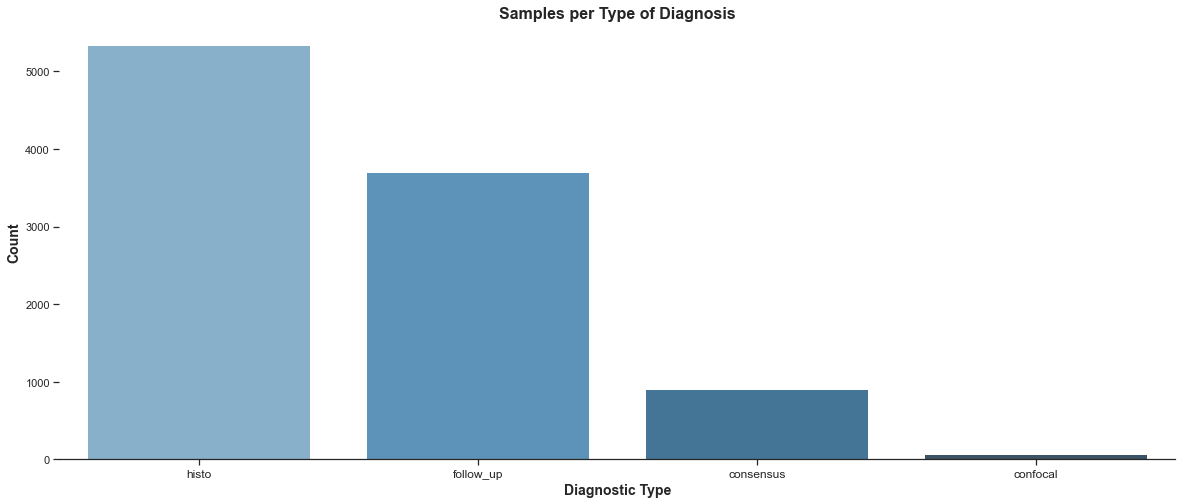

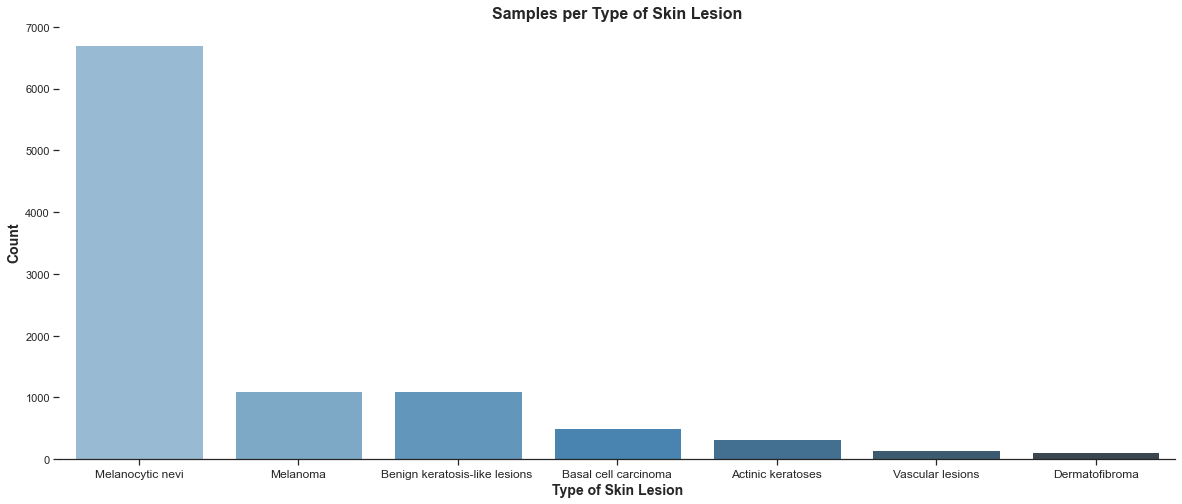

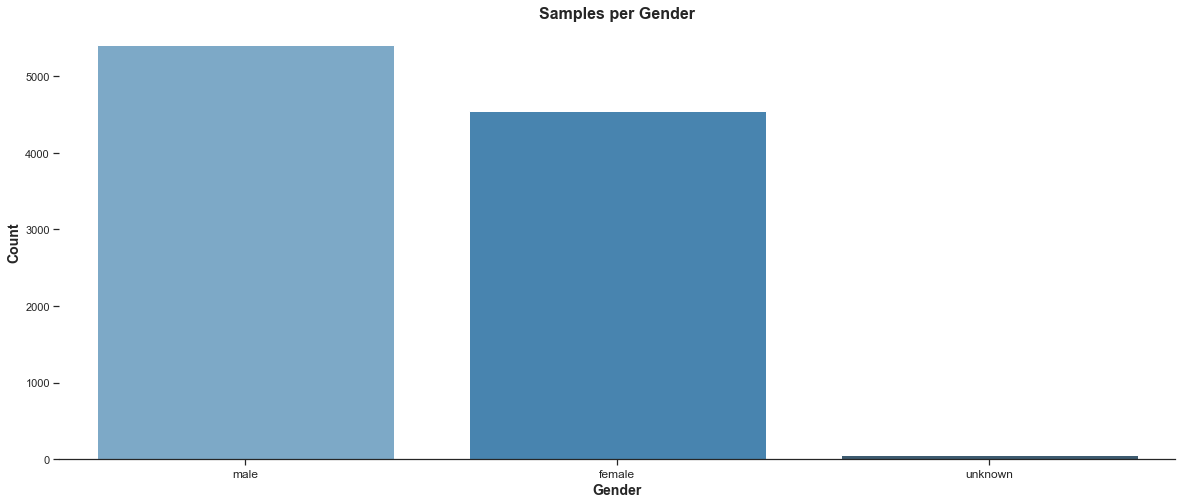

In [6]:
countplot(skin_df,'dx_type', 'Diagnostic Type', 'Count', 'Samples per Type of Diagnosis')
countplot(skin_df,'cell_type', 'Type of Skin Lesion', 'Count', 'Samples per Type of Skin Lesion')
countplot(skin_df,'sex', 'Gender', 'Count', 'Samples per Gender')

In [7]:
base_skin_dir = os.path.join('..', 'C:/Users/Annu/Desktop/Sem 4')



imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}



lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [8]:
skin_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))



skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [9]:
skin_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))



skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [10]:
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

In [11]:

features=skin_df.drop(columns=['cell_type_idx'],axis=1)
target=skin_df['cell_type_idx']


x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20,random_state=123)


x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_train_mean)/x_train_std


y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)


x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1,random_state=123)
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

In [12]:

input_shape = (75, 100, 3)
num_classes = 7

optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

epochs = 100
batch_size = 20


learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=5, verbose=1, factor=0.5, min_lr=0.00001)
early_stopping_monitor = EarlyStopping(patience=20,monitor='val_accuracy')


dataaugment = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=90,  
        zoom_range = 0.1,  
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=True,  
        shear_range = 10) 

dataaugment.fit(x_train)

def history(model):
    model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
    history = model.fit(dataaugment.flow(x_train,y_train, batch_size=batch_size),
                        epochs = epochs, validation_data = (x_validate,y_validate),
                        verbose = 0, steps_per_epoch=x_train.shape[0] // batch_size, 
                        callbacks=[learning_rate_reduction,early_stopping_monitor])

    
    loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
    predictions = model.predict(x_test)
    loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=0)
    loss_t, accuracy_t = model.evaluate(x_train, y_train, verbose=0)
    return (predictions,accuracy_t,accuracy_v,accuracy)

In [13]:
base_model = ResNet50(include_top=False, input_shape=(75,100, 3),pooling = 'avg', weights = 'imagenet');

ResNet50model = Sequential()
ResNet50model.add(base_model)
ResNet50model.add(Dropout(0.2))
ResNet50model.add(Dense(128, activation="relu"))
ResNet50model.add(Dropout(0.2))
ResNet50model.add(Dense(num_classes, activation = 'softmax'))


for layer in base_model.layers:
    layer.trainable = True

ResNet50y_pred,ResNet50accuracy_t,ResNet50accuracy_v,ResNet50accuracy = history(ResNet50model)
    
print("ResNet50 Training: accuracy = %f" % (ResNet50accuracy_t))
print("ResNet50 Validation: accuracy = %f" % (ResNet50accuracy_v))
print("ResNet50 Test: accuracy = %f" % (ResNet50accuracy))

ResNet50 Training: accuracy = 0.894036
ResNet50 Validation: accuracy = 0.795511
ResNet50 Test: accuracy = 0.793809
